In [1]:
import os 
import geopandas as gpd 
import rasterio as rio
from rasterio import features
import numpy as np 
import pandas as pd
from rasterio.plot import reshape_as_raster, reshape_as_image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

Vytvořte klasifikační model pro rozlišení tří tříd (ledovec, suť na ledovci a holá půda/kamení). Porovnejte modely Random Forest a MLP architektury pomocí PyTorchu. Modely validujte.

#### Průzkum dat

In [2]:
raster_filename = 'landsat.tif'

In [3]:
with rio.open(raster_filename) as data:
    meta = data.meta
    image = data.read()

print(meta)
print(image.shape)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 500, 'height': 500, 'count': 6, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 624000.0,
       0.0, -30.0, 7750000.0)}
(6, 500, 500)


In [4]:
# Reference ("labels") pro klasifikaci
ref_fn = 'poly_rast.tif'

In [5]:
# Unikátní kódy 
with rio.open(ref_fn) as data:
    labels = data.read(1)

print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=int16), array([245630,   3446,    167,    757], dtype=int64))


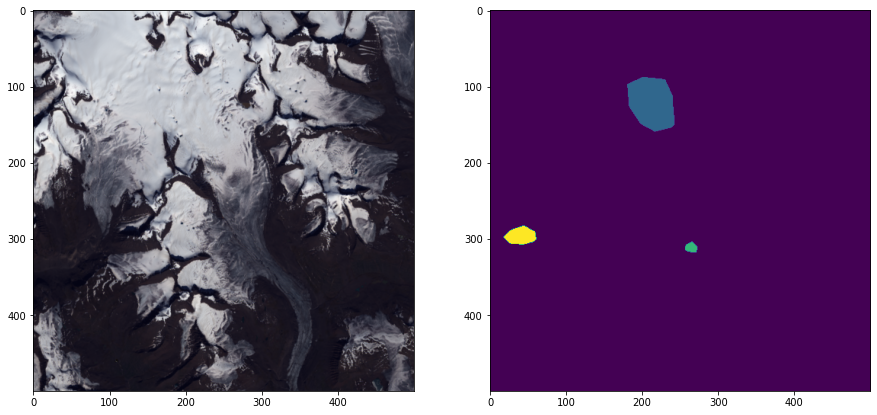

In [6]:
# Vizualizace snímku a reference
blue=image[2]
green=image[1]
red=image[0]

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

blue_norm = normalize(blue)
green_norm = normalize(green)
red_norm = normalize(red)

rgb_image_norm = np.array([blue_norm,green_norm,red_norm])
rgb_image_norm = rio.plot.reshape_as_image(rgb_image_norm)

f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(rgb_image_norm)
ax2.imshow(labels)

#### Příprava dat pro klasifikaci

In [7]:
# vektorizace a výběr refernce 
image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

X = image_reshaped[labels > 0]
y = labels[labels > 0]

print('Vstup X má rozměr: {sz}'.format(sz=X.shape))
print('Výstup y má rozměr: {sz}'.format(sz=y.shape))

Image shape: (6, 500, 500) -> (500, 500, 6)
Vstup X má rozměr: (4370, 6)
Výstup y má rozměr: (4370,)


In [8]:
# ověřte unikátní kódy tříd klasifikace 
np.unique(y, return_counts=True)

(array([1, 2, 3], dtype=int16), array([3446,  167,  757], dtype=int64))

### Random Forest

In [9]:
# rozdělení na trénovací a testovací data set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [10]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2185, 6) (2185, 6)
(2185,) (2185,)


In [11]:
# Inicializace a učení modelu RF modelu 
# n_estimators = number of trees in the forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Příparava pro predikci - vektorizace matice
all_features_for_classification = image_reshaped.reshape(-1,6)
print(f'Image shape for classification: {image_reshaped.shape} -> {all_features_for_classification.shape}')
all_features_for_classification

Image shape for classification: (500, 500, 6) -> (250000, 6)


array([[1625, 1717, 1774, 1386,  109,   96],
       [1517, 1514, 1699, 1230,  104,  115],
       [1509, 1479, 1639, 1305,  108,   96],
       ...,
       [2712, 2719, 2880, 2372,   55,   50],
       [2746, 2900, 3000, 2373,   60,   53],
       [2425, 2415, 2452, 1953,   55,   53]], dtype=int16)

In [13]:
# Predikce
y_pred = model.predict(all_features_for_classification)

In [14]:
print(y_pred.shape)
np.unique(y_pred)

(250000,)


array([1, 2, 3], dtype=int16)

In [15]:
# Návrat do 2D matice
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])

print(f'Predicted labels shape: {y_pred.shape} -> {classified_image.shape}')
print(classified_image)

Predicted labels shape: (250000,) -> (500, 500)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]


In [16]:
# Visualize výsledku 
n = y_pred.max()

colors = dict((
    (0, (0, 0, 0, 255)),      # Nodata
    (1, (26, 222, 228, 255)), # Ledovec 
    (2, (16, 128, 132, 255)), # Suť 
    (3, (200, 200, 200, 255)) # Skála 
))
#  0 - 255 -> float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Klasifikace', n)

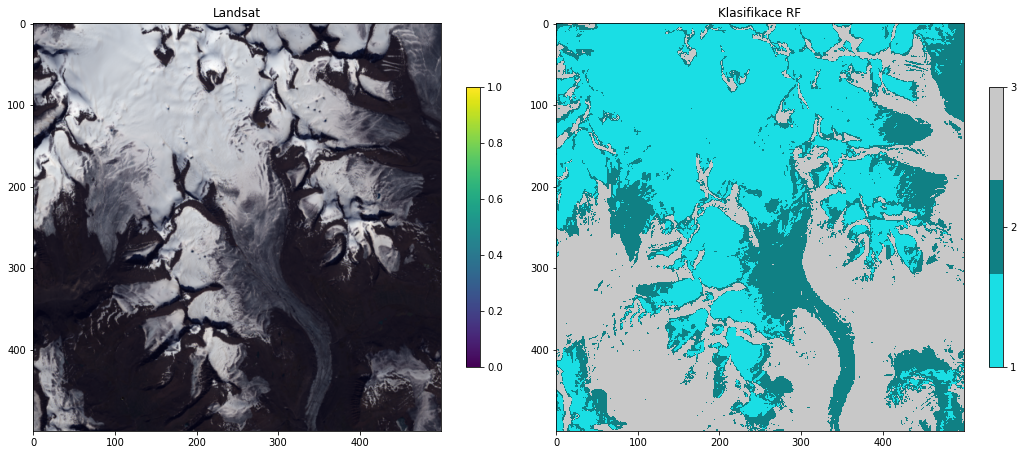

In [17]:
# Mapa klasifikace 
plt.subplot(121)
plt.imshow(rgb_image_norm)
plt.colorbar(shrink=0.4)
plt.title('Landsat')
plt.subplot(122)
plt.imshow(classified_image, cmap=cmap, interpolation='none')
plt.title('Klasifikace RF')
#  ['ice', 'debris', 'bare']
plt.colorbar(cmap=cmap, ticks=np.unique(y), format='%1i', shrink=0.4)
plt.tight_layout()

In [18]:
# presnost na trenovacich datech
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

1.0

In [19]:
# presnost na testovacich datech
y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

1.0

## MLP PyTorch

In [20]:
# Reference pro Pytorch musí být kódovány od 0!!! 
y_torch = y - 1

print(np.unique(y_torch, return_counts=True))

(array([0, 1, 2], dtype=int16), array([3446,  167,  757], dtype=int64))


In [21]:
# Příznky X - dimenze (GT pixely)
print(f'Features X for GT data: {X.shape} \nLabels: {y_torch.shape}') 

Features X for GT data: (4370, 6) 
Labels: (4370,)


In [22]:
# rozdělení na trénovací a testovací, 20% testování 
X_train, X_test, y_train, y_test = train_test_split(X, y_torch, test_size=0.2, random_state=42) 

In [23]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(np.unique(y_train))
print(np.unique(y_test))

(3496, 6) (874, 6)
(3496,) (874,)
[0 1 2]
[0 1 2]


In [24]:
# Třída Dataset pro Landsat-5 data
# vstupní příznaky torch.float32
# reference (labels) torch.long 
class LandsatDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features: numpy pole (n_samples, n_features)
            labels: numpy pole (n_samples,)
        """

        # convert to tensors, features must be torch.float32, labels torch.long
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [25]:
# Vytvořte PyTorch dataset pro trénování a testování LandsatDataset() 
train_dataset = LandsatDataset(X_train, y_train)
test_dataset = LandsatDataset(X_test, y_test)

print(f'Train features shape: {train_dataset.features.shape}, Train labels shape: {train_dataset.labels.shape}')
print(f'Test features shape: {test_dataset.features.shape}, Test labels shape: {test_dataset.labels.shape}')

Train features shape: torch.Size([3496, 6]), Train labels shape: torch.Size([3496])
Test features shape: torch.Size([874, 6]), Test labels shape: torch.Size([874])


In [26]:
# Hyperparametry modelu
input_features = image.shape[0] # Počet kanálů Landsat-5
output_classes = len(np.unique(y_torch))  # Třídy klasifikace

# Model
hidden_size = 8     # skryté jednotky 

# Uceni
batch_size = 32     # Velikost dávky pro klasifikaci 
learning_rate = 0.001 # Rychlost učení 
num_epochs = 30     # Počet epoch 

In [27]:
# Vytvořte PyTorch DataLoader (iterátor) z obou data setů DataLoader() 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Definice modelu

In [28]:
# MLP model (input_size, hidden_size, num_classes), ReLU 
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()

        # input
        self.nn_input = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # 4 hidden layers
        self.hidden_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), 
            nn.ReLU(),
                             
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        # output
        self.nn_output = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        x = self.nn_input(inputs) 

        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i](x)

        x = self.nn_output(x)
        
        return x

In [29]:
# Inicializujte model, ztrátovou funkci pro klasifikaci a optimalizátor
model = MLPClassifier(input_features, hidden_size, output_classes)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

In [30]:
model

MLPClassifier(
  (nn_input): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
  )
  (nn_output): Linear(in_features=8, out_features=3, bias=True)
)

#### Učení modelu

In [31]:
# strata v kazdej epoche
loss_epoch = []

for epoch in range(num_epochs):
    # přepnutí modelu do procesu učení model.train() 
    model.train()
    
    # vynulování celkové ztráty 
    total_loss = 0
    
    # cyklus přes dávky trénovacích dat
    for features, labels in train_loader:
        
        # Predikce (dopředný chod)
        prediction = model(features) 
        
        # ztráta 
        loss = criterion(prediction, labels)
        
        # vynulování gradientu z optimlaizátoru 
        optimizer.zero_grad()
        
        # zpětný chod (backpropagation) 
        loss.backward()
        
        # aktualizace vah 
        optimizer.step()
        
        # aktualizace celkové ztráty 
        total_loss += loss.item()
        
    # ulož ztrátu 
    loss_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], AverageLoss: {total_loss/len(train_loader):.4f}, TotalLoss: {total_loss:.4f}")

Epoch [1/30], AverageLoss: 0.4463, TotalLoss: 49.0948
Epoch [2/30], AverageLoss: 0.0594, TotalLoss: 6.5376
Epoch [3/30], AverageLoss: 0.0531, TotalLoss: 5.8415
Epoch [4/30], AverageLoss: 0.0493, TotalLoss: 5.4276
Epoch [5/30], AverageLoss: 0.0458, TotalLoss: 5.0398
Epoch [6/30], AverageLoss: 0.0427, TotalLoss: 4.7010
Epoch [7/30], AverageLoss: 0.0378, TotalLoss: 4.1540
Epoch [8/30], AverageLoss: 0.0373, TotalLoss: 4.1018
Epoch [9/30], AverageLoss: 0.0331, TotalLoss: 3.6384
Epoch [10/30], AverageLoss: 0.0301, TotalLoss: 3.3140
Epoch [11/30], AverageLoss: 0.0293, TotalLoss: 3.2208
Epoch [12/30], AverageLoss: 0.0275, TotalLoss: 3.0239
Epoch [13/30], AverageLoss: 0.0256, TotalLoss: 2.8186
Epoch [14/30], AverageLoss: 0.0233, TotalLoss: 2.5589
Epoch [15/30], AverageLoss: 0.0221, TotalLoss: 2.4311
Epoch [16/30], AverageLoss: 0.0228, TotalLoss: 2.5085
Epoch [17/30], AverageLoss: 0.0196, TotalLoss: 2.1509
Epoch [18/30], AverageLoss: 0.0184, TotalLoss: 2.0284
Epoch [19/30], AverageLoss: 0.0167, 

Text(0, 0.5, 'Total Loss pre epoch')

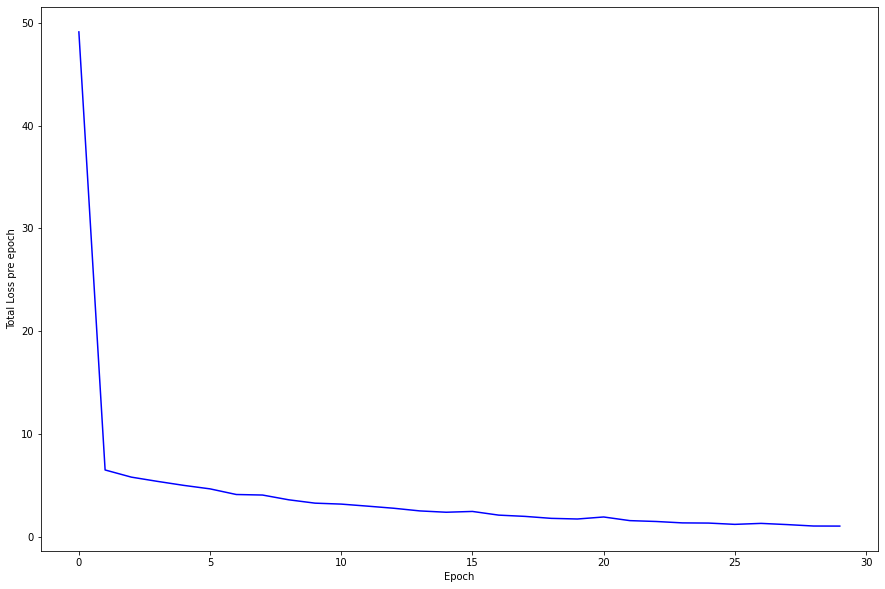

In [32]:
# Vizualizuj proces učení 
plt.plot(loss_epoch, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss pre epoch')

#### Testování přesnosti

In [33]:
# Testování modelu 

# přepnutí modelu do procesu evaluace (testování)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Celková přesnost testování: {accuracy:.4f}")

Celková přesnost testování: 0.9989


#### Predikce

In [34]:
scene_tensor = torch.tensor(all_features_for_classification, dtype=torch.float32)
print(f'Scene tensor shape: {scene_tensor.shape}')

# prediction
y_pred = model(scene_tensor)
print(f'Predicted labels tensor (class probabilites): {y_pred.shape}')

Scene tensor shape: torch.Size([250000, 6])
Predicted labels tensor (class probabilites): torch.Size([250000, 3])


In [35]:
# Extract class index with the biggest probability
_, predicted_label = torch.max(y_pred, 1)

print(f'Predicted labels: {predicted_label.shape}')
print(predicted_label)

Predicted labels: torch.Size([250000])
tensor([1, 1, 1,  ..., 0, 0, 1])


In [36]:
# Návrat do 2D matice
classified_image_mlp = predicted_label.reshape(image_reshaped.shape[0], image_reshaped.shape[1])

print(f'{predicted_label.shape} -> {classified_image_mlp.shape}')
print(classified_image_mlp)

torch.Size([250000]) -> torch.Size([500, 500])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])


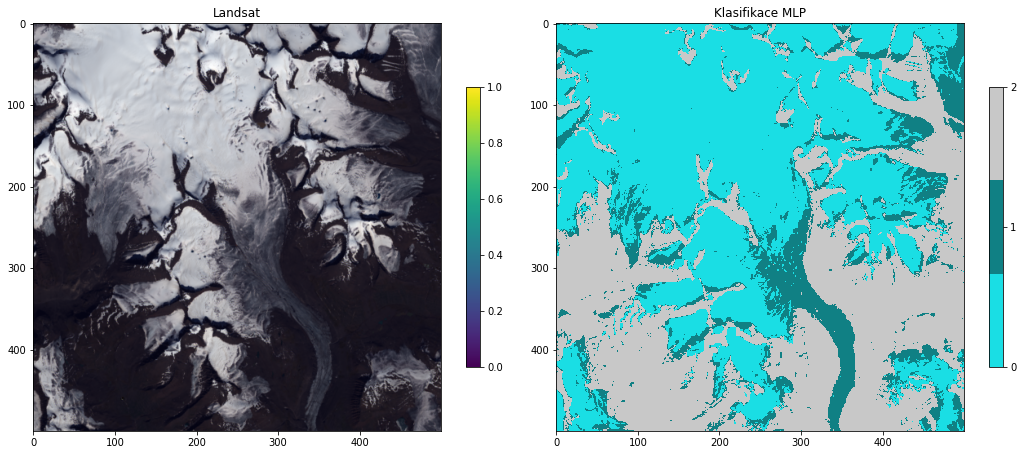

In [37]:
# Mapa klasifikace 
plt.subplot(121)
plt.imshow(rgb_image_norm)
plt.colorbar(shrink=0.4)
plt.title('Landsat')
plt.subplot(122)
plt.imshow(classified_image_mlp, cmap=cmap, interpolation='none')
plt.title('Klasifikace MLP')
#  ['ice', 'debris', 'bare']
plt.colorbar(cmap=cmap, ticks=np.unique(y_torch), format='%1i', shrink=0.4)
plt.tight_layout()

#### Export klasifikacii

In [38]:
rf_fp = 'rf_classification.tif'
mlp_fp = 'mlp_classification.tif'

classification_meta = meta.copy()
classification_meta.update({"count": 1})

# RF
with rio.open(rf_fp, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)

# MLP
with rio.open(mlp_fp, "w", **classification_meta) as dest:
    dest.write(classified_image_mlp, indexes=1)